#### Following [wmt analysis: full3D_tutorial.ipynb](https://github.com/hdrake/xwmt/blob/main/examples/full3D_tutorial.ipynb) and [Baltic example](https://github.com/hdrake/xwmb/blob/main/examples/Baltic_example.ipynb)


In [1]:
import xarray as xr
import numpy as np

In [2]:
import xwmb
import xwmt
import xgcm

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
xwmb.__version__, xwmt.__version__, xgcm.__version__

('0.0.1', '0.0.3', '0.8.2.dev15+g7492277')

In [6]:
hfdrake_path = "/pub/hfdrake/datasets/CM4_MHW_blobs/"
ds = xr.open_mfdataset(f"{hfdrake_path}/data/WMT_monthly/ocean_month_rho2.0186*", chunks={"xh":360, "yh":270, "time":1}) #chunks={'time':1})
snap = xr.open_mfdataset(f"{hfdrake_path}/data/WMT_monthly/ocean_month_rho2_snap.0186*", chunks={"xh":360, "yh":270, "time":1}) #chunks={'time':1})
static = xr.open_mfdataset(f"{hfdrake_path}/data/WMT_monthly/ocean_month_rho2.static.nc", chunks={"xh":360, "yh":270}) #chunks={'time':1})

In [9]:
# Merge snapshots with time-averages
snap = snap.rename({
    **{'time':'time_bounds'},
    **{v:f"{v}_bounds" for v in snap.data_vars}
})
ds = xr.merge([ds.sel(time=ds.time[1:]), snap])

In [10]:
# Add core coordinates of static to ds
ds = ds.assign_coords({
    "areacello": xr.DataArray(static["areacello"].values, dims=('yh', 'xh',)), # Required for area-integration
    "lon": xr.DataArray(static["geolon"].values, dims=('yh', 'xh',)), # Required for calculating density if not already provided!
    "lat": xr.DataArray(static["geolat"].values, dims=('yh', 'xh',)), # Required for calculating density if not already provided!
    "xq": xr.DataArray(static["xq"].values, dims=('xq',)),
    "yq": xr.DataArray(static["yq"].values, dims=('yq',)),
    "deptho": xr.DataArray(static["deptho"].values, dims=('yh', 'xh',)),
    "geolon": xr.DataArray(static["geolon"].values, dims=('yh', 'xh',)),
    "geolat": xr.DataArray(static["geolat"].values, dims=('yh', 'xh',)),
    "geolon_c": xr.DataArray(static["geolon_c"].values, dims=('yq', 'xq',)),
    "geolat_c": xr.DataArray(static["geolat_c"].values, dims=('yq', 'xq',)),
})

# xgcm grid for dataset
coords = {
    'X': {'center': 'xh', 'right': 'xq'},
    'Y': {'center': 'yh', 'right': 'yq'},
    'Z': {'center': 'rho2_l', 'outer': 'rho2_i'}
}
metrics = {
    ('X','Y'): "areacello", # Required for area-integration
}

ds['tos'] = ds['thetao'].isel(rho2_l=0)
ds['sos'] = ds['so'].isel(rho2_l=0)

grid = xgcm.Grid(ds.copy(), coords=coords, metrics=metrics, boundary={'X':'extend', 'Y':'extend', 'Z':'extend'}, autoparse_metadata=False)

In [11]:
wm = xwmt.WaterMass(grid)

In [12]:
ds

<xarray.Dataset>
Dimensions:                         (time: 59, rho2_l: 74, yh: 1080, xh: 1440,
                                     nv: 2, rho2_i: 75, yq: 1080,
                                     time_bounds: 60, xq: 1440)
Coordinates: (12/17)
  * nv                              (nv) float64 1.0 2.0
  * rho2_i                          (rho2_i) float64 997.0 ... 1.039e+03
  * rho2_l                          (rho2_l) float64 1.004e+03 ... 1.038e+03
  * time                            (time) object 0186-02-15 00:00:00 ... 019...
  * xh                              (xh) float64 -299.7 -299.5 ... 59.78 60.03
  * yh                              (yh) float64 -80.39 -80.31 ... 89.84 89.95
    ...                              ...
  * yq                              (yq) float64 -80.35 -80.27 ... 89.89 90.0
    deptho                          (yh, xh) float32 nan nan nan ... nan nan nan
    geolon                          (yh, xh) float32 -299.7 -299.5 ... 60.0 60.0
    geolat                          (yh, xh) float32 -79.81 -79.81 ... 64.11
    geolon_c                        (yq, xq) float32 -299.6 -299.4 ... -300.0
    geolat_c                        (yq, xq) float32 -79.77 -79.77 ... 64.06
Data variables: (12/36)
    S_advection_xy                  (time, rho2_l, yh, xh) float32 dask.array<chunksize=(1, 74, 270, 360), meta=np.ndarray>
    average_DT                      (time) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    average_T1                      (time) object dask.array<chunksize=(1,), meta=np.ndarray>
    average_T2                      (time) object dask.array<chunksize=(1,), meta=np.ndarray>
    time_bnds                       (time, nv) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    Sh_tendency_vert_remap          (time, rho2_l, yh, xh) float32 dask.array<chunksize=(1, 74, 270, 360), meta=np.ndarray>
    ...                              ...
    so_bounds                       (time_bounds, rho2_l, yh, xh) float32 dask.array<chunksize=(1, 74, 270, 360), meta=np.ndarray>
    thetao_bounds                   (time_bounds, rho2_l, yh, xh) float32 dask.array<chunksize=(1, 74, 270, 360), meta=np.ndarray>
    thkcello_bounds                 (time_bounds, rho2_l, yh, xh) float32 dask.array<chunksize=(1, 74, 270, 360), meta=np.ndarray>
    volcello_bounds                 (time_bounds, rho2_l, yh, xh) float32 dask.array<chunksize=(1, 74, 270, 360), meta=np.ndarray>
    tos                             (time, yh, xh) float32 dask.array<chunksize=(1, 270, 360), meta=np.ndarray>
    sos                             (time, yh, xh) float32 dask.array<chunksize=(1, 270, 360), meta=np.ndarray>
Attributes:
    filename:            ocean_month_rho2.018601-019012.S_advection_xy.nc
    title:               CM4_piControl_C_restartyear148
    associated_files:    areacello: 01860101.ocean_static.nc
    grid_type:           regular
    grid_tile:           N/A
    external_variables:  volcello areacello

In [13]:
import xbudget
budgets_dict = xbudget.load_preset_budget(model="MOM6_3Donly")
xbudget.collect_budgets(grid._ds, budgets_dict)

(10.0, 38.0)

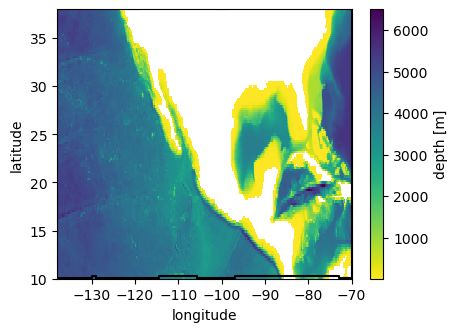

In [14]:
import numpy as np
import regionate
import matplotlib.pyplot as plt

# Note: the properties of this region are quite different from the rest of the Baltic!
name = "MANSO"
#lons = np.array([8.,   20.,  29., 24.5, 24.5, 26.1, 17.5, 11.5])
#lons = np.arange([-138, 0, 3.4])
lons = np.array([-138.,-120.,-100., -70., -70., -100., -120., -138.])
#lats = np.arange(8, 49, 1)
lats = np.array([10., 10., 10., 10., 38., 38., 38., 38.])
#lats = np.array([53.5, 53.5, 54.5,  59.,  61.,  63., 64.5,  62.])
manso_region = regionate.GriddedRegion(name, lons, lats, grid)

plt.figure(figsize=(4.75,3.5))
pc = plt.pcolor(
    grid._ds['geolon_c'],
    grid._ds['geolat_c'],
    grid._ds['deptho'],
    cmap="viridis_r"
)
plt.colorbar(pc, label="depth [m]")
plt.plot(regionate.loop(manso_region.lons), regionate.loop(manso_region.lats), color="k");
plt.xlabel("longitude");
plt.ylabel("latitude");
plt.xlim(np.min(lons), np.max(lons))
plt.ylim(np.min(lats), np.max(lats))

#plt.xlim(-200,5)
#plt.ylim(-10,80)

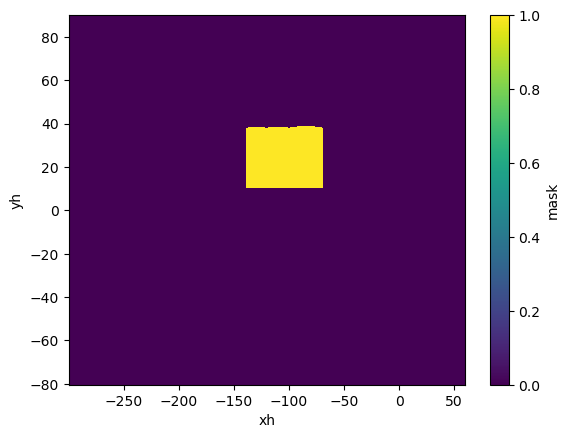

In [15]:
manso_region.mask.plot()

In [23]:
import warnings

lam = "heat"
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    wmb = xwmb.WaterMassBudget(
        grid,
        budgets_dict,
        manso_region.mask,
        assert_zero_transport=True
    )
    wmb.mass_budget(lam, greater_than=True, default_bins=True)
    #wmb.wmt.load()
    wmt = wmb.wmt

In [26]:
temp = wm.grid._ds['thetao'].isel(time =0, yh =500).compute()

In [27]:
z_section = wm.grid._ds['z'].isel(time=0,yh=500).compute()

KeyError: 'z'

In [29]:
wmb.grid._ds['z']

KeyError: 'z'

In [31]:
wm.grid._ds.data_vars

Data variables:
    S_advection_xy                                                  (time, rho2_l, yh, xh) float32 dask.array<chunksize=(1, 74, 270, 360), meta=np.ndarray>
    average_DT                                                      (time) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    average_T1                                                      (time) object dask.array<chunksize=(1,), meta=np.ndarray>
    average_T2                                                      (time) object dask.array<chunksize=(1,), meta=np.ndarray>
    time_bnds                                                       (time, nv) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    Sh_tendency_vert_remap                                          (time, rho2_l, yh, xh) float32 dask.array<chunksize=(1, 74, 270, 360), meta=np.ndarray>
    T_advection_xy                                                  (time, rho2_l, yh, xh) float32 dask.array<chunksize=(1, 74, 270, 360), meta=np.ndarra

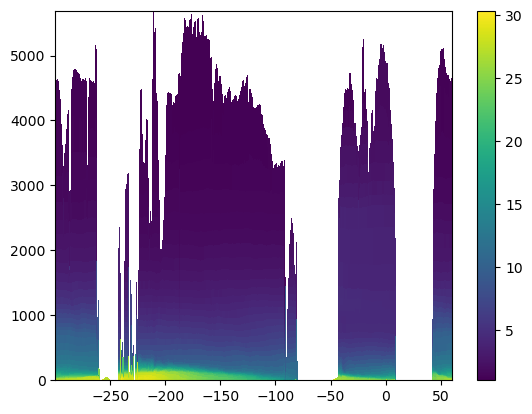

In [24]:
import matplotlib.pyplot as plt

plt.pcolor(
    z_section.xh*xr.ones_like(z_section.rho2_l),
    z_section,
    temp.transpose()
)
plt.colorbar()